In [279]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import scipy.special
from decimal import *

In [261]:
import sys
sys.version

'3.7.1 (default, Nov  7 2018, 15:44:27) \n[GCC 6.3.0 20170516]'

# In-band P2W attack evaluation

We base the attack evaluation of the in-band variant on the evaluation in the whale attack paper.
Therefore, we start by looking at their evaluation in detail.

## 1. Reproduce whale attack to estimate tx exclusion attack costs i.e., revert one block

According to the [Whale attack paper](https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf), the value for the additional bribing cost $ \epsilon $ (in the original paper denoted as $ \delta $) i.e., the bribe, is estimated as follows.

* Let $ \alpha $ be the hashrate of the attacker that works on the attack branch unconditionally 
* Let $ \beta $ be the hashrate of the other miners, some of which beeing rational i.e., $ \alpha + \beta = 1 $ 
* Let $ \beta_m $ be the hashrate of an individual miner which has to decide if he should follow the attack branch or not
* Let $ z $ be the number of blocks that attack chain is behind the attack chain when the race phase starts

Expected reward for $ \beta_m $ if **not joining** the attack, for **one new** block on the main chain if *attack fails*. Value in number of block rewards (normalized to $ 1 $):
$$
\begin{align}
  \frac{ \big( 1 - \big(
                        \frac{\alpha}
                             {\beta}
                   \big)^{z+1} 
         \big) \cdot \beta_m}
       {\beta}
\end{align}
$$

Expected reward for $ \beta_m $ if **joining** the attack, for **one new** block on the attack chain if *attack succeeds*. Value in number of block rewards (normalized to $ 1 $):
\begin{align}
  \frac{ \big( \frac{\alpha + \beta_m}
                    {\beta - \beta_m}
         \big)^{z+1} \cdot \beta_m}
       {\alpha + \beta_m} 
       \cdot ( \epsilon + 1 )
\end{align}

Solved for $ \epsilon $:
$$
\begin{align}
  \epsilon > \frac{ \big( 1 - \big(\frac{\alpha}{\beta}\big)^{z+1} \big)}
                  {\beta} 
             \cdot 
             \frac{ \beta + \beta_m} 
                  { \big(\frac{\alpha + \beta_m}{\beta - \beta_m}\big)^2}
             -1
\end{align}
$$



In [78]:
def whale_attack_bribe(alpha,beta_m,z,beta=None):
    if beta is None:
        beta = 1 - alpha
        #beta = 1 - (alpha + beta_m) 
    return ( (1-(alpha/beta)**(z+1))/beta ) * ( (alpha + beta_m)/ ( (alpha+beta_m)/(beta - beta_m) )**(z+1) ) - 1 

### Compare values with paper
See table 1 in [Whale attack paper](https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf) for values

In [79]:
assert math.isclose(whale_attack_bribe(alpha=0.1,beta_m=0.05,z=6.),31270.040)
assert round(whale_attack_bribe(alpha=0.05,beta_m=0,z=1),2) == 17.95
assert round(whale_attack_bribe(alpha=0.05,beta_m=0.05,z=1),2) == 7.5

In [80]:
t1_alpha=0.15
t1_beta_m=0.10
t1_beta= 1 - t1_alpha
assert round(whale_attack_bribe(t1_alpha,beta_m=t1_beta_m,z=1,beta=t1_beta),2) == 1.56

In [81]:
t1_alpha=0.15
t1_beta_m=0.10
t1_beta= 1 - (t1_alpha + t1_beta_m)
round(whale_attack_bribe(t1_alpha,beta_m=t1_beta_m,z=1,beta=t1_beta),2)

1.16

In [14]:
whale_attack_bribe(alpha=0.2,beta_m=0.05,z=6) # compare with table 682.4

682.3957862854006

In [15]:
whale_attack_bribe(alpha=0.05,beta_m=0.05,z=1) # compare with 7.5

7.502697186178741

In [16]:
whale_attack_bribe(alpha=0.05,beta_m=0.05,z=1) # compare with 7.5

7.502697186178741

### Provide some more examples

In [17]:
whale_attack_bribe(alpha=0.05,beta_m=0,z=1) # small potential bribeable attacker hashrate, no one joins

17.94736842105263

In [18]:
whale_attack_bribe(alpha=0,beta_m=0.05,z=1) 

17.049999999999997

In [19]:
whale_attack_bribe(alpha=0,beta_m=0.1,z=1)

7.1

In [20]:
whale_attack_bribe(alpha=0,beta_m=0.15,z=1)

3.8166666666666655

In [21]:
whale_attack_bribe(alpha=0,beta_m=0.2,z=1)

2.2

In [22]:
whale_attack_bribe(alpha=0.3,beta_m=0.03,z=1)

0.5863592190122804

### Detour

In [23]:
whale_attack_bribe(alpha=0,beta_m=0.382,z=1) # 38.2 % it is feasable without any additional reward

-0.00019895287958116015

Interestingly the bribe gets negative, i.e., it is more profitable trying to catch-up than switching the chain, if you are just one block behind hand have more than $ 38.196601125010515 \%$ of the hashrate. 
Which is exactly:
$$
\frac{1}{\phi^2}
$$

In [35]:
phi = (1 + 5 ** 0.5) / 2
phi

1.618033988749895

In [36]:
(1/phi**2)

0.38196601125010515

In [91]:
whale_attack_bribe(alpha=0,beta_m=0.3819660112501051,z=1) # small bribe needed

4.440892098500626e-16

In [94]:
whale_attack_bribe(alpha=0,beta_m=0.3819660112501052,z=1) # no bribe needed

-4.440892098500626e-16

$ 38.196601125010515 \%$ is also the threshold when the probability to catch-up one block becomes greater than the hashrate:

General catch up condition $ a_z $ from:
* https://arxiv.org/pdf/1402.2009.pdf
* https://bitcoin.org/bitcoin.pdf


Classical parameter names:
* $p$ = hashrate of the honest network
* $q$ = hashrate of the attacker
$$
p + q = 1
$$
* $n$ = number of confirmation blocks, including and on top of the block which includes the respective transaction which needs to be confirmed or double-spend respectively

The probability to **ever** catch-up if $ z $ blocks behind, where one block is added to $z$ when the honest miners find a block and one block is substracted from $ z $ when the attacker finds a block i.e.,

The catch-up probability is a simplification of the *recurrance relation*, where $ q = \alpha $ and $ p = \beta $, given as:
$$
\begin{align}
    a_z &= p \cdot a_{z+1} + q \cdot a_{z-1} \\
        &= min(q/q,1)^{max(z+1,0)} 
\end{align}
$$


In [76]:
def catch_up(q,z):
    if q >= 0.5:
        return 1.0
    return ( q/(1-q) )**(z+1)

In [85]:
catch_up(0.38,1)

0.3756503642039542

In [84]:
catch_up(q=0.381966011250105,z=1) # success probability lower than hashrate

0.38196601125010465

In [86]:
catch_up(q=0.38196601125010515,z=1) # success probability equal to hashrate

0.3819660112501051

In [87]:
catch_up(q=0.3819660112501052,z=1) # success probability higher than hashrate

0.3819660112501054

### Visualize the barrier when the bribe gets negative compared to hashrate 

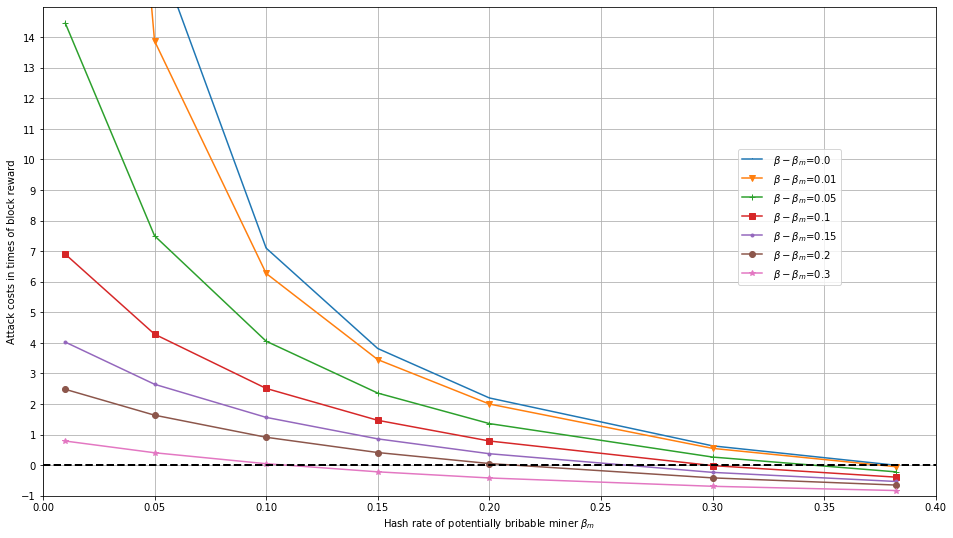

In [101]:
def fig_bribing_costs_tx_exclusion():
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle((',','v', '+', 's','.', 'o', '*','1','D','x','^'))
    
    alpha   = [ 0.00, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3,  ]
    beta_m = [ 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.382 ]
    z = 1 
    
    for o in alpha:
        plt.plot(beta_m, [ whale_attack_bribe(alpha=o,beta_m=o_m,z=z) for o_m in beta_m ] , marker=next(marker), label=" $ \\beta - \\beta_m$=" + str(o))

    # tidy up the figure
    ax.grid(True)
    #ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.57))
    ax.legend(loc='center right', bbox_to_anchor=(0.90, 0.57))
    #ax.set_title("Attack success probability")
    ax.set_xlabel("Hash rate of potentially bribable miner $ \\beta_m $")
    ax.set_ylabel("Attack costs in times of block reward")
    ax.set_ylim([-1, 15])
    ax.set_xlim([0,0.4])
    
    # draw line at 0 
    #plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    plt.plot([0, 100], [0, 0], color='k', linestyle='--', linewidth=2)
    
    plt.yticks(np.arange(-1, 15, step=1))
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 17})
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17) 
    #plt.savefig("figures/tx_exclusion_costs_z=1.png", dpi=100) # sage image
    plt.show()

fig_bribing_costs_tx_exclusion()

## 2. Adapt whale attack to fit our model 

### Rename variable with respect to our Nomenclature 

We can adapt the whale attack to fit our model for (in-band) tx exclusion. 
The whale attack rewritten in our Nomenclature looks as follows:

* Let $ \alpha = 0 $ be the hashrate of the attacker. 
* Let $ \omega_\alpha $ be the estimated hashrate of the other bribable miners which are assumed to work on the attacker branch 
* Let $ \beta $ be the hashrate of honest miners which will never accept a bribe to work on the attacker branch - but they will work on the attack branch if it becomes the longest branch. 
* Let $ \omega_m $ be the hashrate of an individual rational/bribable miner which has to decide if he should follow the attack branch or not $ \omega_m + \omega_\alpha + \alpha + \beta = 1 $ 
* Let $ z $ be the number of blocks that attack chain is behind the attack chain when the race phase starts.
In our case $ z = 1 $

Expected reward in number of block rewards (normalized to $ 1 $) for **one new** block on the main chain if *attack fails*:
$$
\begin{align}
  \frac{ \big( 1 - \big(
                        \frac{\alpha + \omega_\alpha}
                             {\beta + \omega_m}
                   \big)^{z+1} 
         \big) \cdot \omega_m}
       {\beta + \omega_m}
\end{align}
$$

Expected reward in number of block rewards (normalized to $ 1 $) for **one new** block on the attack chain if *attack succeeds*:
$$
\begin{align}
  \frac{ \big( \frac{\alpha + \omega_\alpha + \omega_m}
                    {\beta}
         \big)^{z+1} \cdot \omega_m}
       {\alpha + \omega_\alpha + \omega_m} 
       \cdot ( \epsilon + 1 )
\end{align}
$$

The equations for the expected reward if the attack succeeds has to be larger than the equation for the expected rewards when the attack fails. Solve this inequality for $ \epsilon $:
$$
\begin{align}
  \epsilon > \frac{ \big( 1 - \big(\frac{\alpha + \omega_\alpha}{\beta + \omega_\beta + \omega_m}\big)^{z+1} \big)}
                  {\beta + \omega_m} 
             \cdot 
             \frac{ \alpha + \omega_\alpha + \omega_m} 
                  { \big(\frac{\alpha + \omega_\alpha + \omega_m}{\beta + \omega_\beta}\big)^2}
             -1
\end{align}
$$

In [129]:
def txexclusion_attack_bribe(omega_a,omega_m,alpha=0,beta=None,z=1):
    if beta is None:
        beta = 1 - (alpha + omega_a + omega_m) 
    assert math.isclose(alpha + beta + omega_a + omega_m, 1)
    
    if beta == 0:
        return 0 
    if beta == 1.0:
        return None
    
    bribe = ( 
             ( ( 1 - ( ( alpha + omega_a)  / (beta + omega_m) )**(z+1) ) / (beta + omega_m) ) * 
             ( (alpha + omega_a + omega_m) / 
               ( (alpha + omega_a + omega_m)/ ( beta ) )**(z+1) ) 
              - 1 
            )
    if bribe <= 0.0:
        return 0
    else:
        return bribe
    
    #return bribe

In [125]:
whale_attack_bribe(alpha=0.1,beta_m=0.05,z=1)

4.285779606767259

In [126]:
txexclusion_attack_bribe(omega_a=0.1,omega_m=0.05,alpha=0,beta=None,z=1)

4.285779606767259

### Visualize the attack costs whithout negative bribe

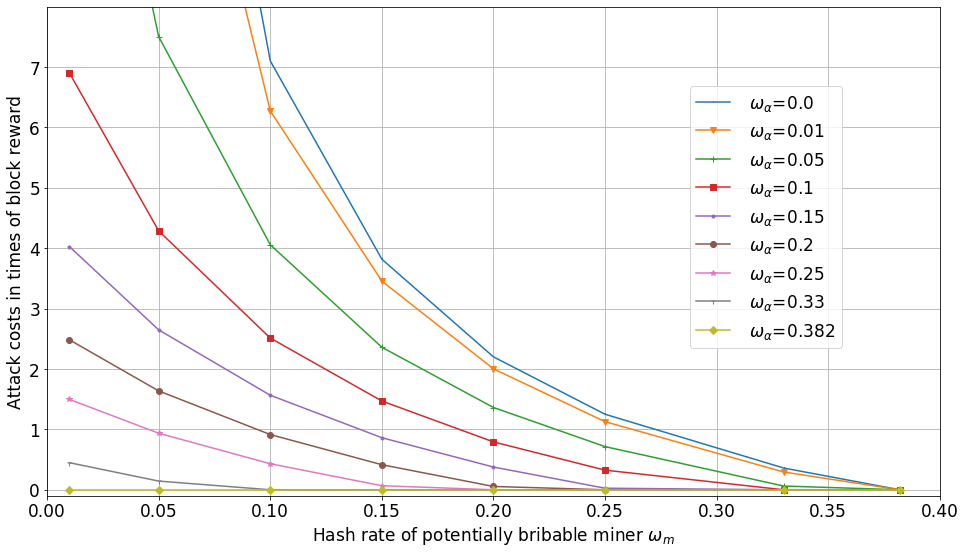

In [130]:
def fig_bribing_costs_tx_exclusion():
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle((',','v', '+', 's','.', 'o', '*','1','D','x','^'))
    
    omega_a = [ 0.0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.33, 0.382 ]
    omega_m = [ 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.33, 0.382 ]
    z = 1 
    
    for o_a in omega_a:
        plt.plot(omega_m, [ txexclusion_attack_bribe(omega_a=o_a,omega_m=o_m,z=z) for o_m in omega_m ] , marker=next(marker), label=" $\\omega_\\alpha$=" + str(o_a))

    # tidy up the figure
    ax.grid(True)
    #ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.57))
    ax.legend(loc='center right', bbox_to_anchor=(0.90, 0.57))
    #ax.set_title("Attack success probability")
    ax.set_xlabel("Hash rate of potentially bribable miner $ \\omega_m $")
    ax.set_ylabel("Attack costs in times of block reward")
    ax.set_ylim([-0.1, 8])
    ax.set_xlim([0,0.4])
    
    plt.yticks(np.arange(0, 8, step=1))
    
    # draw line at 0 
    #plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    #plt.plot([0, 100], [0, 0], color='k', linestyle='--', linewidth=2)
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 17})
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17) 
    #plt.savefig("figures/.png", dpi=100) # sage image
    plt.show()

fig_bribing_costs_tx_exclusion()

### Calculate attack success probabilities and expected profit

This basically wraps the `catch_up()` function with the right parameters defined above. 

In this case $ \omega_m $ joins the attacker.

In [168]:
def P_attack_success_with_m(omega_a,omega_m,z=1,alpha=0,beta=None):
    if beta is None:
        beta = 1 - ( alpha + omega_a + omega_m  ) 
    assert math.isclose(alpha + beta + omega_a + omega_m, 1)
    
    return catch_up(( alpha + omega_a + omega_m ),z)

In [169]:
P_attack_success_with_m(omega_a=0.0,omega_m=0.382) # 38.2 % attacker

0.3820760151234277

In [170]:
P_attack_success_with_m(omega_a=0.09,omega_m=0.40) # 49 % attacker 

0.923106497500961

In [166]:
P_attack_success_with_m(omega_a=0.3,omega_m=0.40)

1.0

Again wrapping the `catch_up()` function with the right parameters defined above. 

In this case $ \omega_m $ joins the defender.

In [171]:
def P_attack_success_without_m(omega_a,omega_m,z=1,alpha=0,beta=None):
    if beta is None:
        beta = 1 - ( alpha + omega_a + omega_m ) 
    assert math.isclose(alpha + beta + omega_a + omega_m, 1)
    
    return catch_up(( alpha + omega_a ),z)

In [172]:
P_attack_success_without_m(omega_a=0.4,omega_m=0.382)

0.44444444444444453

In [173]:
P_attack_success_without_m(omega_a=0.3,omega_m=0.40)

0.18367346938775514

In [174]:
P_attack_success_without_m(omega_a=0.1,omega_m=0.90)

0.01234567901234568

Calculate the expected profit for the next block in terms of block reward (normalized to 1).
The profit for mining on the **main chain** is given by the success probability that the attack fails,
times the probability that $ m $ finds the next block on the main chain. 

In [189]:
def profit_main_chain(alpha=0,beta=None,omega_a=0,omega_m=0,z=1):
    if beta is None:
        beta = 1 - (alpha + omega_a + omega_m) 
        
    assert math.isclose(alpha + beta + omega_a  + omega_m, 1)
    
    P_attack_success = P_attack_success_without_m(omega_a=omega_a,
                                                  omega_m=omega_m,
                                                  z=z)
    return ( 
              ( 1 - P_attack_success ) * 
              ( omega_m / ( beta + omega_m ) )
           )

In [190]:
profit_main_chain(omega_a=0.0,omega_m=0.382)

0.382

In [191]:
profit_main_chain(omega_a=0.4,omega_m=0.1)

0.09259259259259259

Calculate the expected profit for the next block in terms of block reward (normalized to 1).
The profit for mining on the **attack chain** is given by the success probability that the attack is successful, times the probability that $ m $ finds the next block on the attack chain, multiplied by the bribe $ \epsilon $. 

In [193]:
def profit_attack_chain(alpha=0,beta=None,omega_a=0,omega_m=0,z=1,epsilon=0):
    if beta is None:
        beta = 1 - (alpha + omega_a + omega_m) 
    assert math.isclose(alpha + beta + omega_a + omega_m, 1)
    
    P_attack_success = P_attack_success_with_m(omega_a=omega_a,
                                               omega_m=omega_m,
                                               z=z)  
    return ( 
              P_attack_success  * 
              ( omega_m / ( alpha + omega_a + omega_m ) )
           ) * ( epsilon + 1 ) 

In [199]:
profit_attack_chain(omega_a=0.0,omega_m=0.382,epsilon=0)

0.3820760151234277

In [198]:
profit_attack_chain(omega_a=0.1,omega_m=0.382,epsilon=0)

0.6862002653508444

In [195]:
profit_attack_chain(omega_a=0.1,omega_m=0.382,epsilon=1)

1.3724005307016889

In [197]:
profit_attack_chain(omega_a=0.1,beta=0.0,omega_m=0.90)

0.9

### Visualize the expected reward

Note that the reward on the main chain slightly increases with low attacker hash rates,
since less hash power is mining on the main chain. This chances when the attackers pass the $ 38.2 \% $ threshold. 

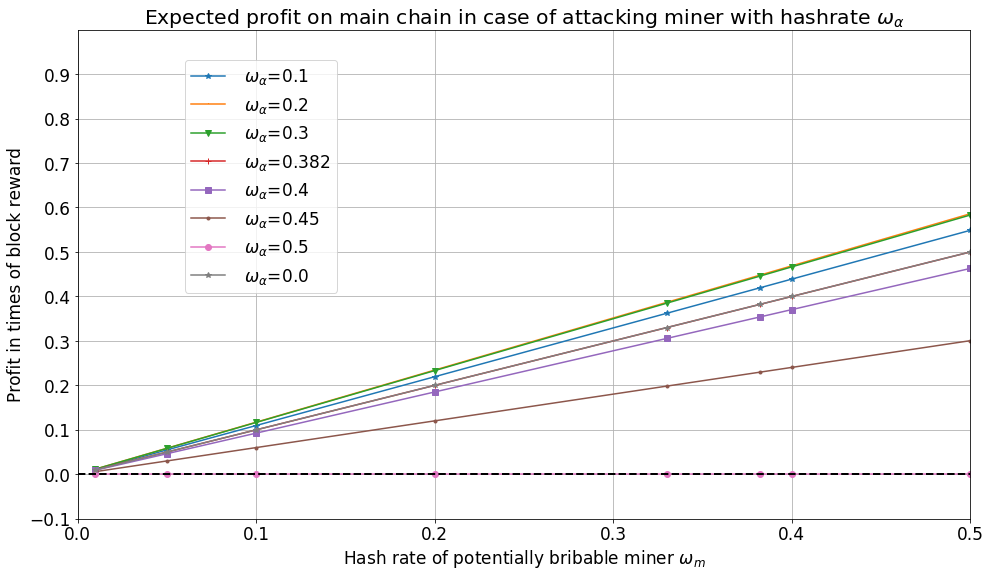

In [218]:
def fig_profit_main_chain():
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle(('*',',','v', '+', 's','.', 'o', '*','1','D','x','^'))
    
    omega_a = [  0.1, 0.2, 0.3, 0.382, 0.4, 0.45, 0.5, 0.0 ]
    #omega_a = [ 0.0, 0.1, 0.2, 0.3, 0.4, ]
    omega_m = [ 0.01, 0.05, 0.1,0.2, 0.33, 0.382, 0.4, 0.5, 0.6 ]
    z = 1 
    
    for o_a in omega_a:
        profit = [ profit_main_chain(omega_a=o_a,omega_m=o_m) for o_m in omega_m ]
        plt.plot(omega_m, profit, marker=next(marker), label=" $\\omega_\\alpha$=" + str(o_a) )
        #for e in epsilon:
        #    plt.plot(omega_m, [ profit_attack_chain(omega_a=o_a,omega_b=0,omega_m=o_m,epsilon=e) for o_m in omega_m ] , marker=next(marker), label=" $\\omega_\\alpha$ =" + str(o_a) + " $ \\epsilon $= " + str(e))

    # tidy up the figure
    ax.grid(True)
    #ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.57))
    ax.legend(loc='center right', bbox_to_anchor=(0.30, 0.70))
    ax.set_title("Expected profit on main chain in case of attacking miner with hashrate $ \\omega_\\alpha $")
    ax.set_xlabel("Hash rate of potentially bribable miner $ \\omega_m $")
    ax.set_ylabel("Profit in times of block reward")
    ax.set_ylim([-0.1, 1])
    ax.set_xlim([0,0.5])
    
    plt.yticks(np.arange(-0.1, 1, step=0.10))
    
    # draw line at 0 
    #plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    plt.plot([0, 100], [0, 0], color='k', linestyle='--', linewidth=2)
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 17})
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17) 
    #plt.savefig("figures/.png", dpi=100) # sage image
    plt.show()

fig_profit_main_chain()

Note that the expected reward is highest when the network is split evenly. 

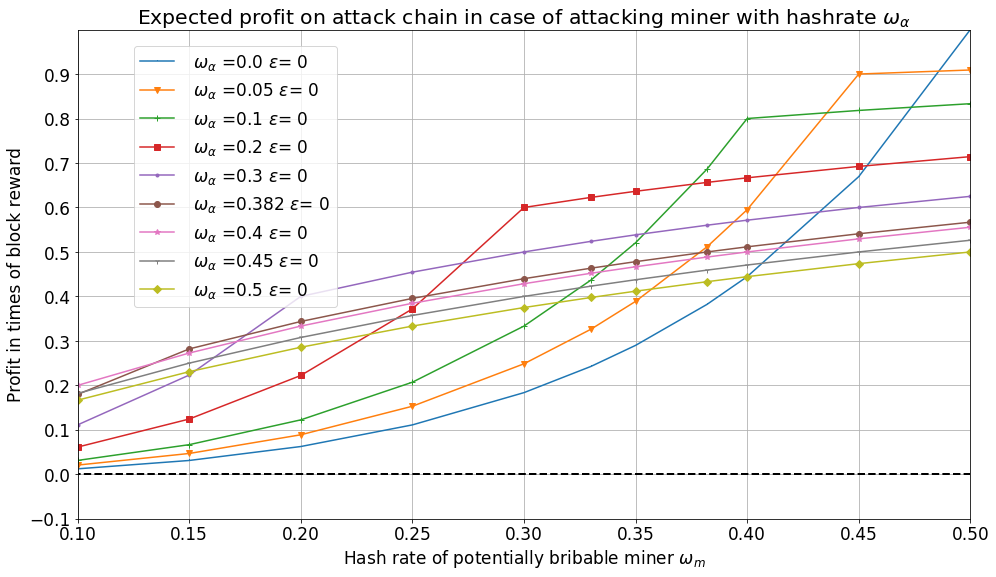

In [220]:
def fig_profit_attack_chain(epsilon=[ 0 ]):
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle((',','v', '+', 's','.', 'o', '*','1','D','x','^'))
    
    #omega_a = [ 0.0, 0.1, 0.33, 0.382 ]
    omega_a = [ 0.0, 0.05, 0.1, 0.2, 0.3, 0.382, 0.4, 0.45, 0.5, ]
    #omega_a = [ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, ]
    omega_m = [ 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.33, 0.35, 0.382, 0.4, 0.45, 0.5, 0.6 ]
    z = 1 
    
    for o_a in omega_a:
        #plt.plot(omega_m, [ profit_main_chain(omega_a=o_a,omega_b=0,omega_m=o_m) for o_m in omega_m ] , marker=next(marker), label=" $\\omega_\\alpha$=" + str(o_a))
        for e in epsilon:
            plt.plot(omega_m, [ profit_attack_chain(omega_a=o_a,omega_m=o_m,epsilon=e) for o_m in omega_m ] , marker=next(marker), label=" $\\omega_\\alpha$ =" + str(o_a) + " $ \\epsilon $= " + str(e))

    # tidy up the figure
    ax.grid(True)
    #ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.57))
    ax.legend(loc='center right', bbox_to_anchor=(0.30, 0.70))
    ax.set_title("Expected profit on attack chain in case of attacking miner with hashrate $ \\omega_\\alpha $")
    ax.set_xlabel("Hash rate of potentially bribable miner $ \\omega_m $")
    ax.set_ylabel("Profit in times of block reward")
    ax.set_ylim([-0.1, 1])
    ax.set_xlim([0.1,0.5])
    
    plt.yticks(np.arange(-0.1, 1, step=0.1))
    
    # draw line at 0 
    #plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    plt.plot([0, 100], [0, 0], color='k', linestyle='--', linewidth=2)
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 17})
    plt.rc('xtick', labelsize=17) 
    plt.rc('ytick', labelsize=17) 
    #plt.savefig("figures/.png", dpi=100) # sage image
    plt.show()

fig_profit_attack_chain()

### Print everything as table

In [222]:
z=1
alpha=0
omega_b=0
beta=None

omega_a=0
omega_m=0

print("""
\\renewcommand{\\arraystretch}{1.3} % increase space between lines
\\begin{table*}[!htpb]
\\centering
\\scriptsize
\\resizebox{0.7\\linewidth}{!}{   % 2 colum view
\\begin{tabular}{c|c|c|c|c|c|c|c|c|}
""",end="")

O_m = [0.05, 0.10, 0.20, 0.30, 0.33, 0.382, 0.40, ]
O_a = [0.0, 0.05, 0.10, 0.20, 0.30, 0.33, 0.382, 0.40, ]

for i in O_m:
    print("\t& $ \\omega_m = $ {} ".format(str(i)),end="")
#print("\\ \\hline")

for omega_a in O_a:
    print("\\\\ \\hline")
    print("$ \\omega_\\alpha = {:.2f} $".format(omega_a),end="")
    for omega_m in O_m:
        if 1 - (omega_a + omega_m) < 0:
            continue

        proift_main_with_m = profit_main_chain(omega_a=omega_a,omega_m=omega_m)
        prob_success_attack_without_m = P_attack_success_without_m(omega_a=omega_a,omega_m=omega_m)
          
        min_cost = txexclusion_attack_bribe(omega_a=omega_a,omega_m=omega_m,z=1)
        
        if min_cost is not None: 
            profit_attack_with_m = profit_attack_chain(omega_a=omega_a,omega_m=omega_m,epsilon=min_cost)
        else:
            min_cost = float("NaN")
            profit_attack_with_m = 0
        
        prob_success_attack_with_m = P_attack_success_with_m(omega_a=omega_a,omega_m=omega_m)
        """
        if profit_attack_with_m > proift_main_with_m:
            mark = "X"
        else:
            mark = " "
        print("o_a = {:4.2f}  b = {:4.2f}  o_m = {:4.2f}  r_main = {:.3f}  p_ma = {:.2f}  e = {:.2f}  r_att = {:.3f}  p_at = {:.3f} {}".format(
                                                     omega_a,
                                                     1 - (omega_a + omega_m),
                                                     omega_m,
                                                     proift_main_with_m,
                                                     1 - prob_success_attack_without_m,
                                                     min_cost,
                                                     profit_attack_with_m,
                                                     prob_success_attack_with_m,
                                                     mark))
        """
        print("""\t& \\makecell[l]{{ $\\beta = {:.3f} $ \\\\ $\\rho= {:.3f}$ \\\\ $\\epsilon = {:.3f}$ \\\\ $\\rho'= {:.3f}$ \\\\ $P = {:.3f}$ }} """.format(
                                                        1 - (omega_a + omega_m),
                                                        proift_main_with_m,
                                                        min_cost,
                                                        profit_attack_with_m,
                                                        prob_success_attack_with_m),end="")
        

    
print("""
\\end{tabular}
}
\\caption{Comparison of minimum bribing attack costs $ \\epsilon $ for certain attack hashrates $ \\omega_\\alpha $ and undecided individual miners $ \\omega_m $.
The table also shows the expected reward of $ m $ if $ \\omega_m $ would be directed towards the attack chain $ \\rho' $, as well as the expected reward $ \\rho $ if $ \\omega_m $ would be directed towards the main chain.}
\\label{tab:txexclib}
\\end{table*}
""")


\renewcommand{\arraystretch}{1.3} % increase space between lines
\begin{table*}[!htpb]
\centering
\scriptsize
\resizebox{0.7\linewidth}{!}{   % 2 colum view
\begin{tabular}{c|c|c|c|c|c|c|c|c|}
	& $ \omega_m = $ 0.05 	& $ \omega_m = $ 0.1 	& $ \omega_m = $ 0.2 	& $ \omega_m = $ 0.3 	& $ \omega_m = $ 0.33 	& $ \omega_m = $ 0.382 	& $ \omega_m = $ 0.4 \\ \hline
$ \omega_\alpha = 0.00 $	& \makecell[l]{ $\beta = 0.950 $ \\ $\rho= 0.050$ \\ $\epsilon = 17.050$ \\ $\rho'= 0.050$ \\ $P = 0.003$ } 	& \makecell[l]{ $\beta = 0.900 $ \\ $\rho= 0.100$ \\ $\epsilon = 7.100$ \\ $\rho'= 0.100$ \\ $P = 0.012$ } 	& \makecell[l]{ $\beta = 0.800 $ \\ $\rho= 0.200$ \\ $\epsilon = 2.200$ \\ $\rho'= 0.200$ \\ $P = 0.062$ } 	& \makecell[l]{ $\beta = 0.700 $ \\ $\rho= 0.300$ \\ $\epsilon = 0.633$ \\ $\rho'= 0.300$ \\ $P = 0.184$ } 	& \makecell[l]{ $\beta = 0.670 $ \\ $\rho= 0.330$ \\ $\epsilon = 0.360$ \\ $\rho'= 0.330$ \\ $P = 0.243$ } 	& \makecell[l]{ $\beta = 0.618 $ \\ $\rho= 0.382$ \\ $\epsilon = 0.000$ 

Get the success probability for catching up $ k $ blocks within $ N $ total blocks from the out-of-band analysis:

In [262]:
# Attack probability of catching-up k blocks within N total blocks
def attack_prob(k,N,omega,beta=None):
    if beta is None:
        beta = 1 - omega
    p = 0
    #for i in range(0,N-k):
    i = 0
    while i <= N-k-1:
        p += ( scipy.special.binom(k+2*i, i) - scipy.special.binom(k+2*i, i-1) ) * omega**(k+i+1) * beta**i
        i += 1
    return p

In [263]:
# Get number of required total blocks s.t. attack success probability is met 
def attack_N(k,omega,success_prob):
        N = 0
        prob = 0
        while prob < success_prob:
            #prob = probCalc_optimized.compute_prob(k, N, omega,beta=1-omega)
            prob = attack_prob(k, N, omega,beta=1-omega)
            N += 1
        return N - 1

In [265]:
# calculate expected number of blocks in which attack is successful i.e., target sucess probability is reached with this amount of N
def attack_expected(k,N,omega,beta=None):
    if beta is None:
        beta = 1 - omega
    P = 0
    p = 0
    e = 0
    i = 0
    while i <= N-k-1:
        # Current probability:
        p = ( scipy.special.binom(k+2*i, i) - scipy.special.binom(k+2*i, i-1) ) * ( ( omega / (omega + beta) )**(k+i+1) ) * ( beta / (omega + beta ) )**i
        # Overall probability:
        P += p
        # Expected value:
        y = i+k+1 # i+k+1 == y == N  
        #print(P,e,y,p)
        if math.isnan(p):
            #return (P,e)
            return e
        e += p * y
        i += 1
        p = 0
    #return (P,e) 
    return e

In [267]:
# Probability of attack success depending on teams
for o in [0.1,0.2,0.3,0.33,0.4,0.5]:
    print()
    for om in [0.05,0.1,0.2,0.25,0.3,0.33,0.4,0.49]:
        if o + om <= 0.51:
            continue
            
        # probability that the attack fails if m does not help 
        P_fail = (1 - P_attack_success_without_m(o,om,1) )*100 
        # probability that the attack is successful if m helps
        P_success = P_attack_success_with_m(o,om,1)*100
        # number of blocks to reach target success probability with given hashrate
        N_success = attack_N(k=1,omega=o + om,success_prob=0.99)
        # expected number of blocks number of blocks 
        N_expected = math.ceil(attack_expected(k=1,N=N_success,omega=o + om))
        print("𝜔 = {:4.2f}   𝜔_𝑚 = {:4.2f}   total = {:4.2f}  P_s = {:7.2f} %  P_f = {:7.2f} %   N_s = {:4}   N_e = {:4}".format(o,
                                                                                             om,
                                                                                             o + om,
                                                                                             P_success,
                                                                                             P_fail,
                                                                                             N_success,
                                                                                             N_expected          
                                                                                             ))


𝜔 = 0.10   𝜔_𝑚 = 0.49   total = 0.59  P_s =  100.00 %  P_f =   98.77 %   N_s =   47   N_e =    6

𝜔 = 0.20   𝜔_𝑚 = 0.33   total = 0.53  P_s =  100.00 %  P_f =   93.75 %   N_s =  228   N_e =   14
𝜔 = 0.20   𝜔_𝑚 = 0.40   total = 0.60  P_s =  100.00 %  P_f =   93.75 %   N_s =   40   N_e =    6
𝜔 = 0.20   𝜔_𝑚 = 0.49   total = 0.69  P_s =  100.00 %  P_f =   93.75 %   N_s =   15   N_e =    4

𝜔 = 0.30   𝜔_𝑚 = 0.25   total = 0.55  P_s =  100.00 %  P_f =   81.63 %   N_s =  110   N_e =   10
𝜔 = 0.30   𝜔_𝑚 = 0.30   total = 0.60  P_s =  100.00 %  P_f =   81.63 %   N_s =   40   N_e =    6
𝜔 = 0.30   𝜔_𝑚 = 0.33   total = 0.63  P_s =  100.00 %  P_f =   81.63 %   N_s =   27   N_e =    5
𝜔 = 0.30   𝜔_𝑚 = 0.40   total = 0.70  P_s =  100.00 %  P_f =   81.63 %   N_s =   14   N_e =    4
𝜔 = 0.30   𝜔_𝑚 = 0.49   total = 0.79  P_s =  100.00 %  P_f =   81.63 %   N_s =    8   N_e =    3

𝜔 = 0.33   𝜔_𝑚 = 0.20   total = 0.53  P_s =  100.00 %  P_f =   75.74 %   N_s =  228   N_e =   14
𝜔 = 0.33   𝜔_𝑚 = 0.25   to

## Tx exclusion in-band compared to `censorshipcon`

* http://fc18.ifca.ai/bitcoin/papers/bitcoin18-final14.pdf

> Once included in the blockchain, the uncle block’s miner is sent
an uncle block reward of $ c_{uncle} = (1−\frac{\delta}{8}) \cdot c_{block} $,
where $ \delta $ is the distance (number of blocks) between the competing main block
$ b^{i}_{A,main} $ and the publisher block $ b^{i+\delta}_{publ} $.  
As  of  January  2018,  the  full  block  reward  is  $ 3 $  ETH  and  the  maximum
distance permitted for an uncle block to be included in the blockchain is $ 6 $.

> His uncle block reward is the subsidy provided  by  the  network  for  the  briber,  and  his  final  payout  is  calculated  as $ c_{payout} = c_{bribe} + c_{block} − c_{uncle} $. 

> Subsidy  and  expectation  values: Alice can maximise her subsidy by minimising
the number of blocks $ \delta $ it takes until a bribed block is included in the blockchain
as  an  uncle  block.  Ideally,  she  should  include  uncle  blocks  in  her  next  block.
otherwise $ \delta $ may  range  between  1  and  6  if  an  uncle  is  delayed  entry.  
Before highlighting the impact of this subsidy for Alice, recall that she also receives an
additional  publisher  reward $ c_{pub} = \frac{1}{32} \cdot c_{block} $ for  each  uncle  block  she  includes.
Hence for one uncle, Alice only has to pay Bob $ c_{payout} > \frac{4\delta -1}{32} \cdot c_{block} $ to guarantee him a higher payout than if he had won the full block reward. 
If she includes two uncle blocks, **she has to pay** $ c_{payout} > \frac{4\delta -1}{16} \cdot c_{block} $ to ensure both blocks have a higher payout.



In [224]:
def epsilon_censorshipcon(delta,num_uncles_included=2,blockreward=1):
    assert delta > 0 and delta < 7, "Delta for uncle block inclusion not wihtin valid range"
    assert num_uncles_included > 0 and num_uncles_included < 3, "Invalid number of uncles per block for this attack"
    if num_uncles_included == 2:
        return ( (4 * delta - 1)/16 ) * blockreward
    if num_uncles_included == 1:
        return ( (4 * delta - 1)/32 ) * blockreward

In [232]:
epsilon_censorshipcon(1,1) # cheapest scenario, 1 block delta and one unlce block included

0.09375

In [233]:
epsilon_censorshipcon(1,2)

0.1875

In [235]:
epsilon_censorshipcon(3,2) # somewhere in the middle

0.6875

In [236]:
epsilon_censorshipcon(6,1)

0.71875

In [237]:
epsilon_censorshipcon(6,2) # most expansive scenario, 6 block delta and two uncle blocks included

1.4375

### Costs of owning substantial amounts of attacker hashrate $ \alpha \geq 0.33 $ 

* https://www.crypto51.app/

#### Ethereum
1 h 51% attack = $90,388 USD

1 ETH = 158 USD 

$r_e$ = 2 ETH + fees $\approx$ 2.05 ETH 

In [239]:
funds_51_attack_USD = 90388
eth = 158
blockrewads_eth = 2.05
eth_block_interval = 15

In [240]:
funds_51_attack_ETH = funds_51_attack_USD / eth
funds_51_attack_ETH

572.0759493670886

In [241]:
funds_33_attack_ETH = funds_51_attack_ETH * (0.33/0.51)
funds_33_attack_ETH

370.1667907669397

In [244]:
blockrewards_33_attack_ETH = funds_33_attack_ETH / blockrewads_eth
blockrewards_33_attack_ETH

180.56916622777547

In [246]:
costs_of_tx_exclusion_attack_ib_per_block_in_times_of_block_reward = 17

In [247]:
number_of_blocks_tx_exclusion_ib_can_be_executed = int(blockrewards_33_attack_ETH / costs_of_tx_exclusion_attack_ib_per_block_in_times_of_block_reward)
number_of_blocks_tx_exclusion_ib_can_be_executed

10

In [248]:
time_tx_exlcusion_ib_can_be_executed = (number_of_blocks_tx_exclusion_ib_can_be_executed * eth_block_interval)/60
time_tx_exlcusion_ib_can_be_executed

2.5

## Probability of mining a sequence of $ n = 2,3,4,... $ blocks in a row with hashrate $ p $ within $ N $ total blocks

In [268]:
# probability to NOT mine one of the next n blocks with hashrate q
q = 0.33
n = 1
(1-q)**n

0.6699999999999999

In [269]:
q = 0.33
n = 6
(1-q)**n

0.09045838216899994

In [270]:
# probability to mine one of the next n blocks with hashrate q
q = 0.33
n = 1
1-( (1-q)**n )

0.33000000000000007

In [271]:
q = 0.33
n = 6
1-( (1-q)**n )

0.9095416178310001

We can use a finita Markov chain to calculate the exact probability of mining $ n $ 
blocks in a row within the next $ N $ total blocks, having $ \omega $ hashrate ($\beta = 1 - \omega$).

<img src="./figures/markov_chain.png" width="400" height="100">


In [274]:
M_t = np.zeros(shape=(5,3))
M_t

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [275]:
M_t[0][2] = 1
M_t

array([[0., 0., 1.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [276]:
def gen_matrix(n,N,q):
    q = q
    p = 1 - q 
    
    M = np.zeros(shape=(N,N))
    M_init = np.zeros(shape=(1,N))
    
    return M,M_init

gen_matrix(7,8,0.8)

(array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0.]]))

In [280]:
# probability to mine at least n squential blocks of the next N blocks with hahsrate q 
def P_seq_of_n_within_N(n,N,q,pprint=False):
    if N < n:
        return 0
    
    q = Decimal(q)
    p = Decimal( 1 - q )
    
    # start state 
    M_init = np.zeros(shape=(1,n+1))
    M_init[0][0] = 1 
    
    # transition matrix of markov chain
    M = np.zeros(shape=(n+1,n+1))
    
    # start state self reference 
    M[0][0] = p
    
    # final failed state S_n
    M[n][n] = 1 # stay in final state
    M[n-1][n] = q # transition in final state
    
    # All other states and their propabilities: 
    for s in range(1,n):
        M[s-1][s] = q
        M[s][0] = p

    # convert array to matrix
    M = np.asmatrix(M)
    M_init = np.asmatrix(M_init)
    
    P = (M_init * M**int(N))
    
    if pprint:
        print(M)
        print(M_init)
        print(P)
        
    return P.item(n)

P_seq_of_n_within_N(2,6,0.33,True)

[[0.67 0.33 0.  ]
 [0.67 0.   0.33]
 [0.   0.   1.  ]]
[[1. 0. 0.]]
[[0.45570497 0.16475797 0.37953706]]


0.37953705923099995

In [283]:
P_seq_of_n_within_N(2,100,0.1,True)

[[0.9 0.1 0. ]
 [0.9 0.  0.1]
 [0.  0.  1. ]]
[[1. 0. 0.]]
[[0.36470365 0.03680779 0.59848855]]


0.598488553518309

In [281]:
P_seq_of_n_within_N(6,100,2/3,True)

[[0.33333333 0.66666667 0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.66666667 0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.66666667 0.         0.
  0.        ]
 [0.33333333 0.         0.         0.         0.66666667 0.
  0.        ]
 [0.33333333 0.         0.         0.         0.         0.66666667
  0.        ]
 [0.33333333 0.         0.         0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  1.        ]]
[[1. 0. 0. 0. 0. 0. 0.]]
[[0.00958356 0.00663177 0.00458915 0.00317566 0.00219754 0.00152069
  0.97230163]]


0.9723016287695403

In [282]:
P_seq_of_n_within_N(6,100,1/3,True)

[[0.66666667 0.33333333 0.         0.         0.         0.
  0.        ]
 [0.66666667 0.         0.33333333 0.         0.         0.
  0.        ]
 [0.66666667 0.         0.         0.33333333 0.         0.
  0.        ]
 [0.66666667 0.         0.         0.         0.33333333 0.
  0.        ]
 [0.66666667 0.         0.         0.         0.         0.33333333
  0.        ]
 [0.66666667 0.         0.         0.         0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  1.        ]]
[[1. 0. 0. 0. 0. 0. 0.]]
[[0.61116662 0.20390971 0.06803246 0.02269836 0.00757308 0.00252668
  0.08409307]]


0.08409307467149553